In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import cv2

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import torchvision
from torchvision import transforms
import torchvision.models as models


## Utils
import joblib
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
%matplotlib inline

/Users/tuchsanai/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/tuchsanai/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <9E417059-FF86-3C93-B8D5-8A071C12B008> /Users/tuchsanai/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <4552650E-25ED-37A0-9D7F-D677F7410133> /Users/tuchsanai/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:

CONFIG = {
    'EPOCHS': 50,
    'img_size': 224,
    'seed': 22,
    'train_batch_size': 50,
    'test_batch_size': 50,
    'num_classes': 2,
    'device' : "mps" if getattr(torch,'has_mps',False) else "gpu" if torch.cuda.is_available() else "cpu"
}

CONFIG

{'EPOCHS': 50,
 'img_size': 224,
 'seed': 22,
 'train_batch_size': 50,
 'test_batch_size': 50,
 'num_classes': 2,
 'device': 'mps'}

# Index

In [3]:
Train_Base_path = "./alien_vs_predator_data/train/"

timage=[]
tlabels=[]
for folder in os.listdir(Train_Base_path):
    if os.path.isdir(Train_Base_path+folder):
        for file in os.listdir(Train_Base_path+folder):
            timage.append(Train_Base_path+folder+"/"+file)
            tlabels.append(folder)
    
print("number of train images",len(timage))

number of train images 694


In [4]:

Validate_Base_path = "./alien_vs_predator_data/validation/"

vimage=[]
vlabels=[]
for folder in os.listdir(Validate_Base_path):
    if os.path.isdir(Validate_Base_path+folder):
        for file in os.listdir(Validate_Base_path+folder):
            vimage.append(Validate_Base_path+folder+"/"+file)
            vlabels.append(folder)

print("number of validate images",len(vimage))

number of validate images 200


# Lablled data Training

In [5]:
df_train_data = {'Images':timage, 'labels':tlabels} 
df_train_data = pd.DataFrame(df_train_data) 
df_train_data.sample(10)


,Images,labels
635,./alien_vs_predator_data/train/alien/182.jpg,alien
515,./alien_vs_predator_data/train/alien/36.jpg,alien
376,./alien_vs_predator_data/train/alien/174.jpg,alien
614,./alien_vs_predator_data/train/alien/7.jpg,alien
506,./alien_vs_predator_data/train/alien/280.jpg,alien
245,./alien_vs_predator_data/train/predator/81.jpg,predator
190,./alien_vs_predator_data/train/predator/23.jpg,predator
550,./alien_vs_predator_data/train/alien/278.jpg,alien
514,./alien_vs_predator_data/train/alien/20.jpg,alien
142,./alien_vs_predator_data/train/predator/111.jpg,predator


In [6]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  694 non-null    object
 1   labels  694 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


In [7]:
df_train_data = {'Images':timage, 'labels':tlabels} 
df_train_data = pd.DataFrame(df_train_data) 

lb = LabelEncoder()
df_train_data['encoded_labels'] = lb.fit_transform(df_train_data['labels'])
df_train_data.sample(10)

,Images,labels,encoded_labels
259,./alien_vs_predator_data/train/predator/94.jpg,predator,1
78,./alien_vs_predator_data/train/predator/277.jpg,predator,1
103,./alien_vs_predator_data/train/predator/315.jpg,predator,1
414,./alien_vs_predator_data/train/alien/199.jpg,alien,0
204,./alien_vs_predator_data/train/predator/279.jpg,predator,1
358,./alien_vs_predator_data/train/alien/229.jpg,alien,0
605,./alien_vs_predator_data/train/alien/142.jpg,alien,0
10,./alien_vs_predator_data/train/predator/215.jpg,predator,1
89,./alien_vs_predator_data/train/predator/15.jpg,predator,1
619,./alien_vs_predator_data/train/alien/96.jpg,alien,0


# Lablled data Validation

In [8]:
df_val_data = {'Images':vimage, 'labels':vlabels} 
df_val_data = pd.DataFrame(df_val_data) 

lb = LabelEncoder()
df_val_data['encoded_labels'] = lb.fit_transform(df_val_data['labels'])

df_val_data.sample(10)


,Images,labels,encoded_labels
63,./alien_vs_predator_data/validation/predator/5...,predator,1
188,./alien_vs_predator_data/validation/alien/51.jpg,alien,0
114,./alien_vs_predator_data/validation/alien/65.jpg,alien,0
112,./alien_vs_predator_data/validation/alien/59.jpg,alien,0
170,./alien_vs_predator_data/validation/alien/96.jpg,alien,0
130,./alien_vs_predator_data/validation/alien/17.jpg,alien,0
148,./alien_vs_predator_data/validation/alien/26.jpg,alien,0
177,./alien_vs_predator_data/validation/alien/6.jpg,alien,0
77,./alien_vs_predator_data/validation/predator/6...,predator,1
141,./alien_vs_predator_data/validation/alien/20.jpg,alien,0


# Dataset and Dataloader

In [9]:
class Dataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['Images'].values
        self.labels = df['encoded_labels'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       
        label = self.labels[index]
        
        
        if self.transforms:
            img = self.transforms(img)
          
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }



data_transforms = {
    'train':
    transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
        transforms.ToTensor(),
       
       
    ]),
    'validation':
    transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
        transforms.ToTensor(),
       
     
    ]),
}

In [10]:
train_dataset = Dataset(df_train_data, transforms=data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=0, shuffle=True, drop_last=True)

val_dataset = Dataset(df_val_data, transforms=data_transforms['validation'])
val_loader = DataLoader(val_dataset, batch_size= CONFIG["test_batch_size"], num_workers=0, shuffle=False, drop_last= False)


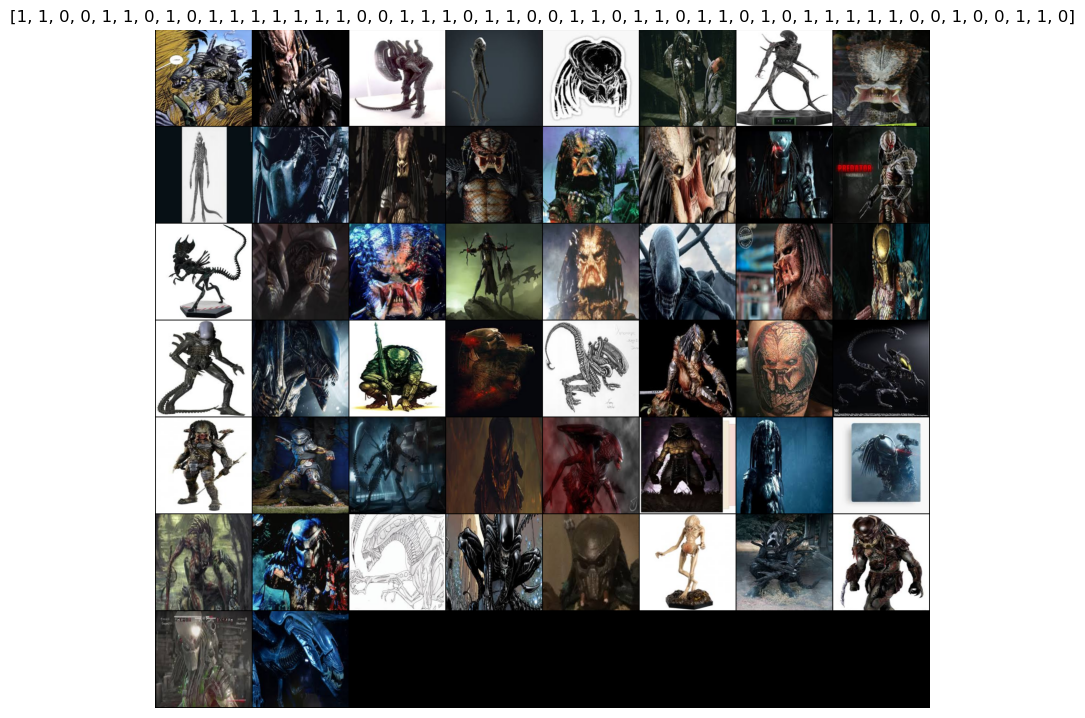

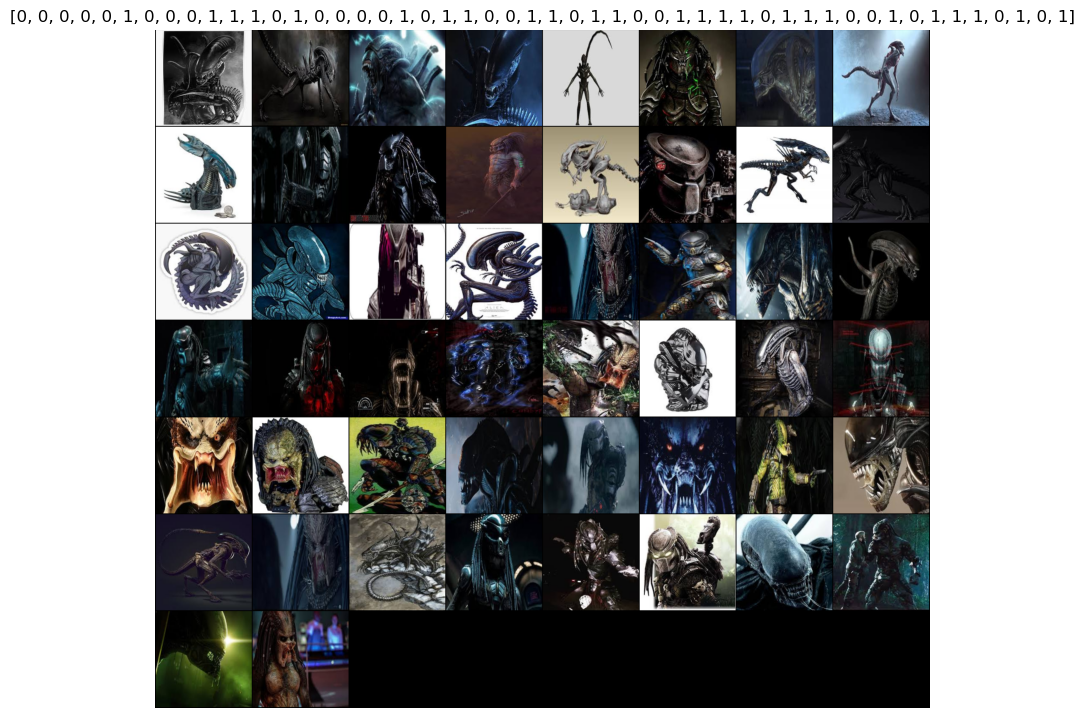

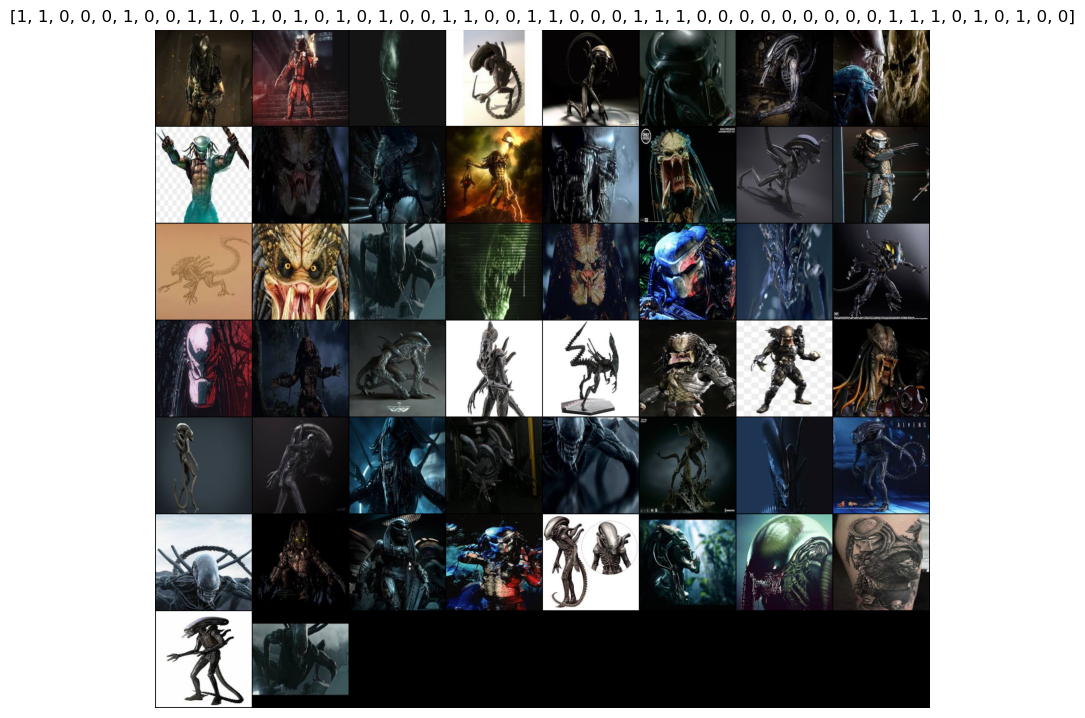

In [11]:
count = 1
for X in train_loader :
    grid = torchvision.utils.make_grid(X['image'], nrow=8)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(X['label'].numpy().tolist());
    
    if count >= 3 :
       break
    count += 1

# Transfer learning

In [12]:
net = models.resnet50(pretrained=False)
net

/Users/tuchsanai/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/tuchsanai/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
net = models.resnet50(pretrained=True)
    
for param in net.parameters():
    param.requires_grad = False   
    
net.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2))




/Users/tuchsanai/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import torch.optim as optim

device = CONFIG['device']

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.97)

#lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [15]:
def save_model(path):
    torch.save({
                'epoch': 15,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'train_loss': training_loss,
                }, path)

In [16]:
import time

def train(model, dataloader, criterion, optimizer, device, epoch):
    
    model.to(device)
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    start_time = time.time()  # Calculate start time

    
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(y_pred.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        max_memory_allocated = torch.cuda.max_memory_allocated(device=torch.device("cuda"))
        # Update progress bar
        print(f"\rTraining({epoch}) [{(batch_idx+1)*len(X_batch)}/{len(dataloader.dataset)} "
              f"({100. * batch_idx / len(dataloader):.0f}%)] "
              f"Loss: {running_loss/(batch_idx+1):.4f} "
              f"Accuracy: {correct/total:.4f} "
              f"GPU Memory: {max_memory_allocated/(1000*1024**2):.4f} G "
              f"Epoch time: {time.time()-start_time:.2f} seconds", end="")


    print("")
    train_accuracy = correct / total

    return running_loss/(batch_idx+1) , train_accuracy


def test(model, dataloader, device, best_accuracy,epoch, save_path):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0

    for batch_idx,  batch in enumerate(dataloader):
        X_batch, y_batch = batch['image'].to(device), batch['label'].to(device)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(y_pred.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        max_memory_allocated = torch.cuda.max_memory_allocated(device=torch.device("cuda")) 
        # Update progress bar
        print(f"\rTesting({epoch}) [{(batch_idx+1)*len(X_batch)}/{len(dataloader.dataset)} "
              f"({100. * batch_idx / len(dataloader):.0f}%)] "
              f"Test Loss: {running_loss/(batch_idx+1):.4f} "
              f"Test Accuracy: {correct/total:.4f} ", end="")
            
              

    # Save model if accuracy is better than previous best
    test_accuracy = correct / total

    # if test_accuracy > best_accuracy:
    #     best_accuracy = test_accuracy
    #     torch.save(model.state_dict(), save_path)
    #     print(f"\nModel saved with accuracy: {best_accuracy:.4f}", end="")
    # else :
    #     print(f"\nModel not saved, best accuracy: {best_accuracy:.4f}", end="")    
   
   
    return running_loss/(batch_idx+1) , test_accuracy 




num_epochs = CONFIG['EPOCHS']
best_accuracy = 0
model = net


Train_loss, Train_accuracy  = [], []
Test_Loss, Test_accuracy    = [], [],

for epoch in range(num_epochs):
    
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, epoch)
    test_loss ,test_accuracy = test(model, val_loader, device, best_accuracy, epoch, f"best_epoch.pt") 
    
    Train_loss.append(train_loss)
    Train_accuracy.append(train_accuracy)
    Test_Loss.append(test_loss)
    Test_accuracy.append(test_accuracy)
    
    

Training(0) [650/694 (92%)] Loss: 0.6958 Accuracy: 0.5154 GPU Memory: 0.0000 G
Testing(0) [200/200 (75%)] Test Loss: 0.6899 Test Accuracy: 0.5300 
Training(1) [650/694 (92%)] Loss: 0.6806 Accuracy: 0.5785 GPU Memory: 0.0000 G
Testing(1) [200/200 (75%)] Test Loss: 0.6742 Test Accuracy: 0.6450 
Training(2) [650/694 (92%)] Loss: 0.6647 Accuracy: 0.6846 GPU Memory: 0.0000 G
Testing(2) [200/200 (75%)] Test Loss: 0.6594 Test Accuracy: 0.7300 
Training(3) [650/694 (92%)] Loss: 0.6477 Accuracy: 0.7600 GPU Memory: 0.0000 G
Testing(3) [200/200 (75%)] Test Loss: 0.6450 Test Accuracy: 0.7600 
Training(4) [650/694 (92%)] Loss: 0.6335 Accuracy: 0.7892 GPU Memory: 0.0000 G
Testing(4) [200/200 (75%)] Test Loss: 0.6310 Test Accuracy: 0.7950 
Training(5) [650/694 (92%)] Loss: 0.6163 Accuracy: 0.8569 GPU Memory: 0.0000 G
Testing(5) [200/200 (75%)] Test Loss: 0.6174 Test Accuracy: 0.8150 
Training(6) [650/694 (92%)] Loss: 0.6009 Accuracy: 0.8738 GPU Memory: 0.0000 G
Testing(6) [200/200 (75%)] Test Loss: 0

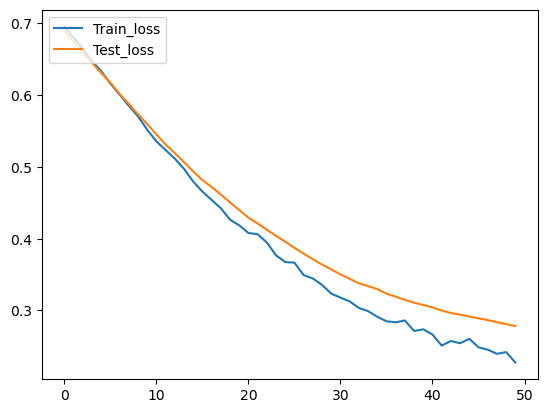

In [21]:
plt.plot(Train_loss)
plt.plot(Test_Loss)
plt.legend(['Train_loss', 'Test_loss'], loc='upper left')


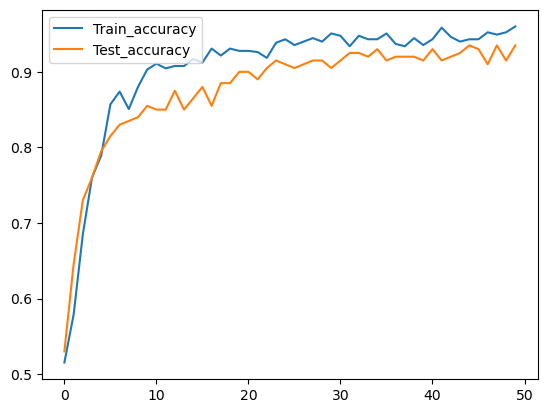

In [22]:
plt.plot(Train_accuracy)
plt.plot(Test_accuracy)
plt.legend(['Train_accuracy', 'Test_accuracy'], loc='upper left')